<a href="https://www.kaggle.com/code/itayashgosavi/deep-care?scriptVersionId=119559268" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breakhis-400x/BreaKHis 400X/test/benign/SOB_B_TA-14-19854C-400-008.png
/kaggle/input/breakhis-400x/BreaKHis 400X/test/benign/SOB_B_PT-14-21998AB-400-045.png
/kaggle/input/breakhis-400x/BreaKHis 400X/test/benign/SOB_B_PT-14-29315EF-400-006.png
/kaggle/input/breakhis-400x/BreaKHis 400X/test/benign/SOB_B_F-14-23060CD-400-009.png
/kaggle/input/breakhis-400x/BreaKHis 400X/test/benign/SOB_B_A-14-22549G-400-028.png
/kaggle/input/breakhis-400x/BreaKHis 400X/test/benign/SOB_B_A-14-22549CD-400-029.png
/kaggle/input/breakhis-400x/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-019.png
/kaggle/input/breakhis-400x/BreaKHis 400X/test/benign/SOB_B_F-14-21998EF-400-004.png
/kaggle/input/breakhis-400x/BreaKHis 400X/test/benign/SOB_B_PT-14-29315EF-400-008.png
/kaggle/input/breakhis-400x/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-027.png
/kaggle/input/breakhis-400x/BreaKHis 400X/test/benign/SOB_B_F-14-25197-400-056.png
/kaggle/input/breakhis-400x/BreaKHis 400X/test/benign/SOB_B_TA-14

In [2]:
import os 
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image


from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from matplotlib import ticker
from sklearn import metrics
from sklearn.model_selection import train_test_split

SEED = 0
tf.random.set_seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'

plt.rc("axes.spines", right=False, top=False)
plt.rc('font', family = 'sherif', size = 10.5)

In [3]:
sample_image = tf.io.read_file('../input/breakhis-400x/BreaKHis 400X/'
                               'test/benign/SOB_B_TA-14-19854C-400-008.png')

## loading the images

at time of writing, the `tf.image.decode_pnd` function in the current Kaggle env cluttered the logs with "Cleanup called ..." messages: 

In [4]:
print(f"Tensorflow version :{tf.__version__}")
img = tf.image.decode_png(sample_image)

Tensorflow version :2.9.2


this made it unpleasant to use the dataset loading utilities
`tf.keras.preprocessing.image_dataset_from_directory` and `tf.keras.preprocessing.image.ImageDataGenerator`; since the 'cleanup called... ' message would be printed hundreds of times and obsure the useful information like training logs.

since the dataset is relatively small, the pillow package was used instead to read and decode the images.

In [5]:
BATCH_SIZE = 28
DATA_DIR = Path('/kaggle/input/breakhis-400x/BreaKHis 400X')
IMG_SIZE = 244
MAX_EPOCHS = 35
classes = {'benign': 0, 'malignant': 1}
class_names = list(classes.keys())

def load_image_dataset(data_dir: Path, split: bool = False) -> tf.data.Dataset:
    """
    Create a Dataset from a Directory with labelled subdir images.
    Args:
        data_dir (Path): Test or train data folder
        split(bool): whether or not to include validation subset
    """
    
    image_files = np.array(list(data_dir.glob('*/*.png')))
    np.random.shuffle(image_files)
    print(f"found {len(image_files):,} images in {data_dir.name} directory")
    X = np.array([np.array(Image.open(file).resize((IMG_SIZE, IMG_SIZE))) for file in image_files])
    y = np.array([classes.get(file.parent.name) for file in image_files])
    
    if split:
        Xt, Xv, yt, yv = train_test_split(X, y, random_state = SEED, test_size = 0.2)
        train = tf.data.Dataset.from_tensor_slices((Xt, yt)).batch(BATCH_SIZE)
        valid = tf.data.Dataset.from_tensor_slices((Xv, yv)).batch(BATCH_SIZE)
        
        print(f"Using {len(Xt):,} images for training, {len(Xv):,} for validation")
        return train, valid
    else:
        return tf.data.Dataset.from_tensor_slices((X, y)).batch(BATCH_SIZE)

In [6]:
train_ds, validation_ds = load_image_dataset(DATA_DIR / "train", split = True)
test_ds = load_image_dataset(DATA_DIR /"test")

found 1,148 images in train directory
Using 918 images for training, 230 for validation
found 545 images in test directory


### EXPLORATORY DATA ANALYSIS
lets look at some images

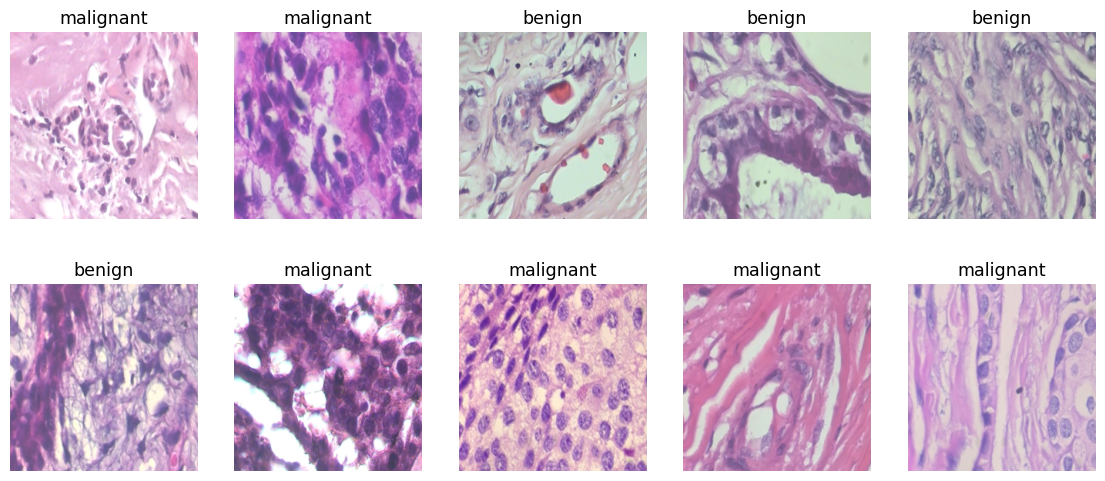

In [7]:
plt.figure(figsize = (14, 6))

for img, labels in train_ds.take(1):
    labels = labels.numpy()
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(img[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis('off')

Target distribution
There is significantly more images of malignant than benign ones

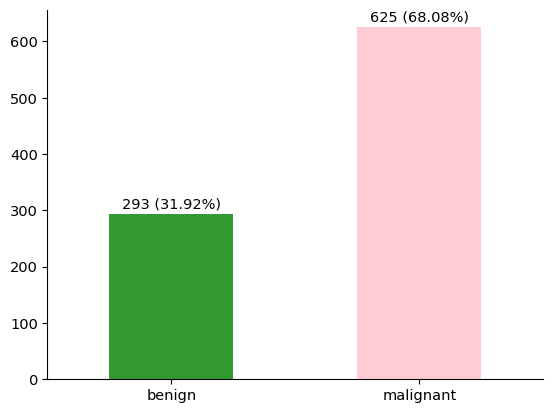

In [8]:
y_train = np.concatenate([y for x, y in train_ds])
label_counts = pd.Series(y_train).value_counts(ascending= True)
ax = label_counts.plot.bar(color = ['green', 'pink'], alpha = 0.8)
ax.bar_label(ax.containers[0], padding = 2, labels = [f"{x} ({x / len(y_train):.2%})" for x in label_counts])
_ = ax.set_xticklabels(["benign", "malignant"], rotation = 0)

when theres class imbalance in classification problems, accuracy becoms an unrealistic matric
To illustrate , a classifier predicting only malignant would get acc score of 67.75% whithout ever identifing any benign cases. But this same model would only achive an ROC-AUC score of 50% (no better than chance)

In [9]:
positive_only_preds = np.ones_like(y_train)

print(f"Accuracy : {metrics.accuracy_score(y_train, positive_only_preds):.2%}"+
     f"\nROC-AUC: {metrics.roc_auc_score(y_train, positive_only_preds):.2%}")

Accuracy : 68.08%
ROC-AUC: 50.00%


Thus we shall use ROC-AUC and confusion matrix for evaluation of the model

Custom Convolutional neural network 
A CNN is a class of ANN that is well suited for image classification problems/


In [10]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
validation_ds =validation_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [11]:
def compile_and_fit_model(model: tf.keras.Model) -> tf.keras.callbacks.History:
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
        loss = tf.keras.losses.BinaryCrossentropy(),
        metrics = [tf.keras.metrics.AUC(name = "roc_auc"), "binary_accuracy"]
    )
    
    early_stopping = EarlyStopping(min_delta = 1e-4, 
                                   patience = 5, 
                                   verbose = 1,
                                  restore_best_weights = True)
    
    reduce_lr = ReduceLROnPlateau(factor=0.25, 
                                  patience=4, 
                                  verbose=1)
    
    history = model.fit(train_ds, validation_data = validation_ds, 
                        epochs = MAX_EPOCHS, 
                        callbacks = [early_stopping, reduce_lr])
    
    performance_df = pd.DataFrame(history.history)
    fig, axes = plt.subplots(ncols = 2, figsize = (11, 4))
    for ax, metric in zip(axes.flat, ["Accuracy", "Loss"]):
        performance_df.filter(like = metric.lower()).plot(ax= ax)
        ax.set_title(metric, size =14, pad = 10)
        ax.set_xlabel("epoch")
    return history

In [12]:
def evaluate_model(model: tf.keras.Model, dataset: tf.data.Dataset= test_ds) -> None:
    loss , auc, accuracy = model.evaluate(dataset, verbose = 0)
    print(f"ROC-AUC: {auc:.5%}")
    print(f"Loss: {loss:.5%}")
    print(f"Accuracy: {accuracy:.5%}\n", sep = "\n")
    result = [(labels, model.predict(images).reshape(-1))
             for images, labels in dataset.take(-1)]
    
    labels = np.concatenate([x[0] for x in result])
    preds = np.concatenate([x[1] for x in result])
    
    fig, axes = plt.subplots(ncols =3, figsize = (15, 4), dpi = 160)
    curves = [metrics.RocCurveDisplay, metrics.PrecisionRecallDisplay]
    for ax, curve in zip(axes[:2], curves):
        curve.from_predictions(labels, preds, ax=ax, name = model.name)
        metrics.ConfusionMatrixDisplay.from_predictions(labels, preds.round().astype("uint8"), ax = axes[2], colorbar = False)
        titles = ["ROC-AUC curve", "Prescision-Recall Curve", "Confusion Matrix"]
        
        for ax, title in zip(axes.flat, titles):
            ax.set_title(title, size=14, pad=10)

In [13]:
def plot_predictions(model):
    plt.figure(figsize = (14, 9))
    for images, labels in test_ds.take(1):
        labels = labels.numpy()
        predicted_labels = model.predict(images).round().astype("uint8").reshape(-1, )
        print("Predicted: ", predicted_labels)
        print("Actual: ", labels)
        for i, (pred, actual) in enumerate(zip(predicted_labels, labels)):
            ax = plt.subplot(4, 7, i+1)
            plt.imshow(images[i].numpy())
            if pred == actual:
                plt.title(class_names[labels[i]], color='green', size = 9)
            else:
                 plt.title(f"{class_names[predicted_labels[i]]}\n"+
                          f"Actual: {class_names[labels[i]]}", color = "red", size = 9)
            plt.axis("off")  

In [14]:
base_model = tf.keras.Sequential([
    layers.Input(shape = (IMG_SIZE, IMG_SIZE, 3)),
    layers.RandomFlip(seed = SEED),
    layers.RandomRotation(0.2, seed = SEED),
    layers.Rescaling(1/.255),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation = 'relu'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.15),
    layers.Dense(256, activation = 'relu'),
    layers.Dropout(0.1),
    layers.Dense(64),
    layers.Dense(1, activation = "sigmoid") 
], name = 'baseCNN')

base_model.summary()

Model: "baseCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 244, 244, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 244, 244, 3)      0         
 tion)                                                           
                                                                 
 rescaling (Rescaling)       (None, 244, 244, 3)       0         
                                                                 
 batch_normalization (BatchN  (None, 244, 244, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 242, 242, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 121, 121, 32)     0   

Epoch 1/35
33/33 [==============================] - 16s 118ms/step - loss: 0.5419 - roc_auc: 0.7701 - binary_accuracy: 0.7495 - val_loss: 5.1559 - val_roc_auc: 0.5000 - val_binary_accuracy: 0.6609 - lr: 0.0010
Epoch 2/35
33/33 [==============================] - 3s 81ms/step - loss: 0.4367 - roc_auc: 0.8593 - binary_accuracy: 0.8388 - val_loss: 2.9122 - val_roc_auc: 0.5128 - val_binary_accuracy: 0.6609 - lr: 0.0010
Epoch 3/35
33/33 [==============================] - 3s 94ms/step - loss: 0.4091 - roc_auc: 0.8699 - binary_accuracy: 0.8519 - val_loss: 2.0002 - val_roc_auc: 0.5535 - val_binary_accuracy: 0.6609 - lr: 0.0010
Epoch 4/35
33/33 [==============================] - 3s 81ms/step - loss: 0.3836 - roc_auc: 0.8864 - binary_accuracy: 0.8638 - val_loss: 1.2302 - val_roc_auc: 0.7034 - val_binary_accuracy: 0.6696 - lr: 0.0010
Epoch 5/35
33/33 [==============================] - 3s 80ms/step - loss: 0.3656 - roc_auc: 0.8972 - binary_accuracy: 0.8725 - val_loss: 1.0730 - val_roc_auc: 0.7259 -

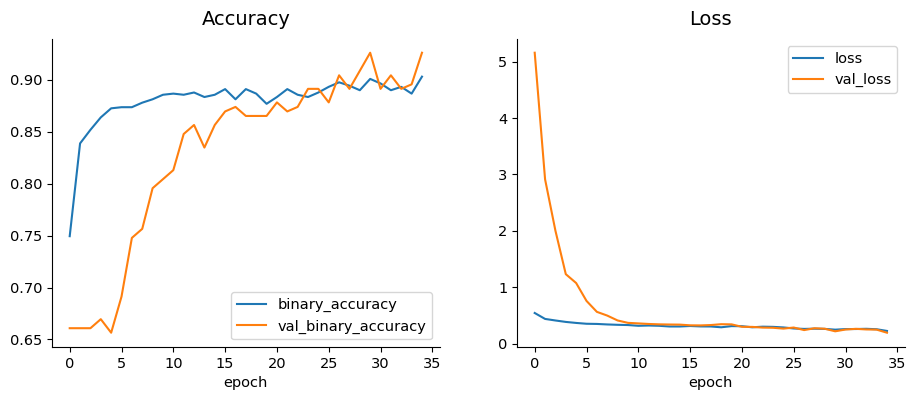

In [15]:
base_history = compile_and_fit_model(base_model)

ROC-AUC: 95.25823%
Loss: 28.08802%
Accuracy: 88.80734%

1/1 [==============================] - 0s 23ms/step


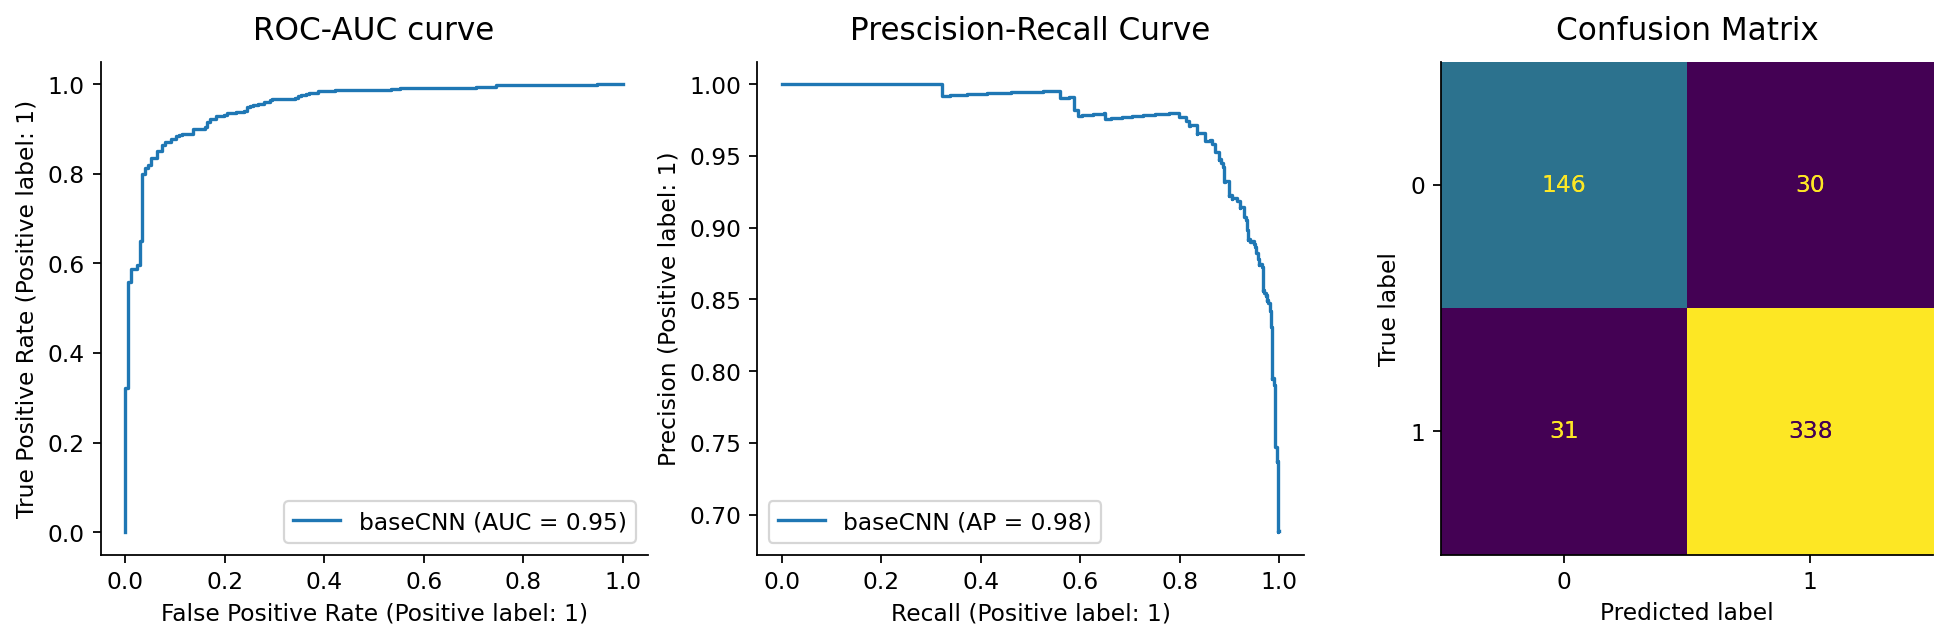

In [16]:
evaluate_model(base_model)

1/1 [==============================] - 0s 23ms/step
Predicted:  [0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0]
Actual:  [1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0]


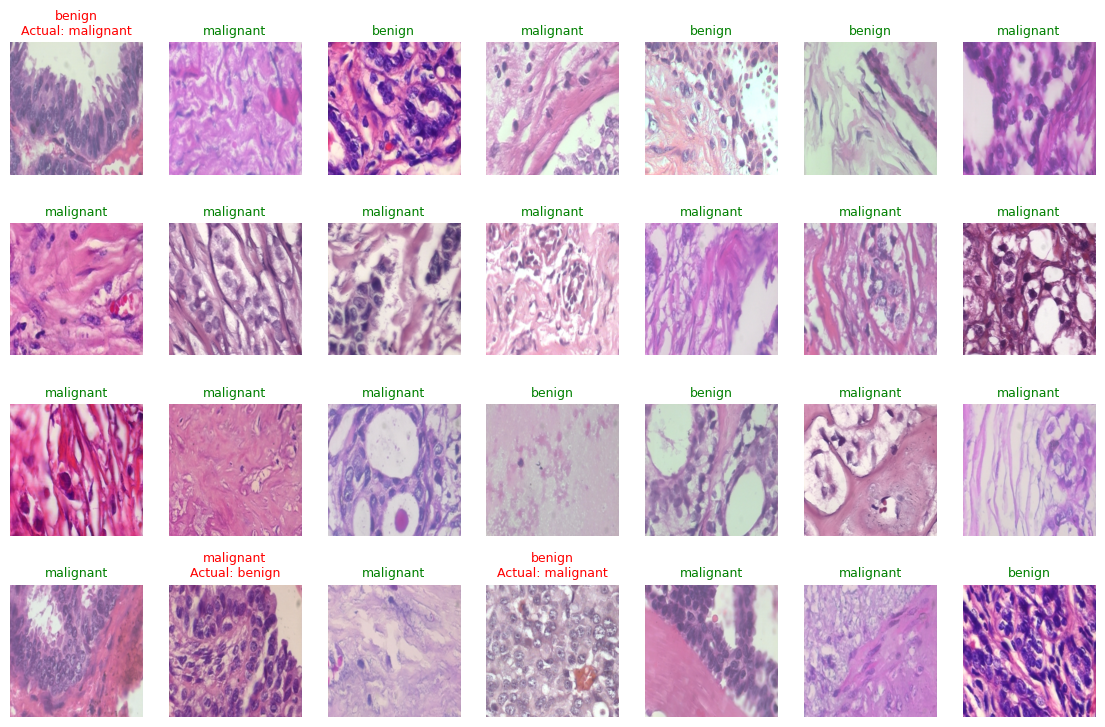

In [17]:
plot_predictions(base_model)

In [18]:
base_model.save("my_model.h5")